# 机器学习工程师纳米学位
## 强化学习
## 项目 4: 训练智能出租车学会驾驶

欢迎来到机器学习工程师纳米学位的第四个项目！在这个notebook文件中，模板代码已经提供给你，有助于你对*智能出租车*的分析和实现学习算法。你无须改动已包含的代码，除非另有要求。 你需要回答notebook文件中给出的与项目或可视化相关的问题。每一个你要回答的问题前都会冠以**'问题 X'**。仔细阅读每个问题，并在后面**'回答'**文本框内给出完整的回答。你提交的项目会根据你对于每个问题的回答以及提交的`agent.py`的实现来进行评分。 

>**提示：** Code 和 Markdown 单元格可通过 **Shift + Enter** 快捷键来执行。此外，Markdown可以通过双击进入编辑模式。

-----

## 开始
在这个项目中，你将构建一个优化的Q-Learning驾驶代理程序，它会操纵*智能出租车* 通过它的周边环境到达目的地。因为人们期望*智能出租车*要将乘客从一个地方载到另一个地方，驾驶代理程序会以两个非常重要的指标来评价：**安全性**和**可靠性**。驾驶代理程序在红灯亮时仍然让*智能出租车*行驶往目的地或者勉强避开事故会被认为是**不安全**的。类似的，驾驶代理程序频繁地不能适时地到达目的地会被认为**不可靠**。最大化驾驶代理程序的**安全性**和**可靠性**保证了*智能出租车*会在交通行业获得长期的地位。

**安全性**和**可靠性**用字母等级来评估，如下：

| 等级 	| 安全性 	| 可靠性 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	| 代理程序没有任何妨害交通的行为，<br/>并且总是能选择正确的行动。| 代理程序在合理时间内到达目的地的次数<br />占行驶次数的100%。 |
|   A   	| 代理程序有很少的轻微妨害交通的行为，<br/>如绿灯时未能移动。| 代理程序在合理时间内到达目的地的次数<br />占行驶次数的90%。 |
|   B   	| 代理程序频繁地有轻微妨害交通行为，<br/>如绿灯时未能移动。| 代理程序在合理时间内到达目的地的次数<br />占行驶次数的80%。 |
|   C   	| 代理程序有至少一次重大的妨害交通行为，<br/>如闯红灯。| 代理程序在合理时间内到达目的地的次数<br />占行驶次数的70%。 |
|   D   	| 代理程序造成了至少一次轻微事故，<br/>如绿灯时在对面有车辆情况下左转。	| 代理程序在合理时间内到达目的地的次数<br />占行驶次数的60%。 |
|   F   	| 代理程序造成了至少一次重大事故，<br/>如有交叉车流时闯红灯。	| 代理程序在合理时间内到达目的地的次数<br />未能达到行驶次数的60%。 |

为了协助评估这些重要的指标，你会需要加载可视化模块的代码，会在之后的项目中用到。运行下面的代码格来导入这个代码，你的分析中会需要它。

In [1]:
# 检查你的Python版本
from sys import version_info
if version_info.major != 2 and version_info.minor != 7:
    raise Exception('请使用Python 2.7来完成此项目')

In [2]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### 了解世界
在开始实现你的驾驶代理程序前，首先需要了解*智能出租车*和驾驶代理程序运行的这个世界（环境）。构建自我学习的代理程序重要的组成部分之一就是了解代理程序的特征，包括代理程序如何运作。原样直接运行`agent.py`代理程序的代码，不需要做任何额外的修改。让结果模拟运行一段时间，以观察各个不同的工作模块。注意在可视化模拟程序（如果启用了），**白色车辆**就是*智能出租车*。

### 问题 1
用几句话，描述在运行默认的`agent.py`代理程序中，你在模拟程序里观察到了什么。一些你可以考虑的情况：
- *在模拟过程中，智能出租车究竟移动了吗？*
- *驾驶代理程序获得了什么样的奖励？*
- *交通灯的颜色改变是如何影响奖励的？*

**提示：** 从顶层的`/smartcab/`目录（这个notebook所在的地方），运行命令
```bash
'python smartcab/agent.py'
```

**回答：**
- 白色的车不移动，停在初始的位置。无论前方路口是红线阻拦，还是没有红线阻拦。红线阻拦，是红灯；没有红线，是绿灯的状态
- 【更新】交通灯变成红灯，车静止，会得到很大的分数奖励，红灯持续期间的静止，分数奖励不多；变成绿灯，如果周围没有车，智能车不动，会扣很大的分数惩罚，绿灯期间后续的静止，扣的分数很小；如果变成绿灯，但是交叉有车，有汇入的车辆，智能车保持不动，会得到奖励。
- 交通灯颜色改变后，车没有做成正确的响应，会被惩罚，如果作出了正确的响应，会得到奖励，且惩罚和奖励都是很大的。

### 理解代码
除了要了解世界之外，还需要理解掌管世界、模拟程序等等如何运作的代码本身。如果一点也不去探索一下*“隐藏”*的器件，就试着去创建一个驾驶代理程序会很难。在顶层的`/smartcab/`的目录下，有两个文件夹：`/logs/` （之后会用到）和`/smartcab/`。打开`/smartcab/`文件夹，探索每个下面的Python文件，然后回答下面的问题。

### 问题 2
- *在*`agent.py`* Python文件里，选择 3 个可以设定的 flag，并描述他们如何改变模拟程序的。*
- *在*`environment.py`* Python文件里，当代理程序执行一个行动时，调用哪个Environment类的函数？*
- *在*`simulator.py`* Python 文件里，*`'render_text()'`*函数和*`'render()'`*函数之间的区别是什么?*
- *在*`planner.py`* Python文件里，*`'next_waypoint()`* 函数会先考虑南北方向还是东西方向?*

**回答：**
- Flag中，‘num_dummies’默认100，初始的车的数量；‘grid_size’多少个路口，默认（8，6）；‘learning’为TRUE，则驾驶车使用Q-Learning
- act(self, agent, action)被调用。Consider an action and perform the action if it is legal.Receive a reward for the agent based on traffic laws.
- render_text(self, trial, testing=False)是在terminal中显示模拟的实时数据，文字形式，非GUI显示；render(self, trial, testing=False)是GUI显示，视觉化。
- 'next_waypoint() 函数 会优先考虑东西方向，然后南北方向

-----
## 实现一个基本的驾驶代理程序

创建一个优化Q-Learning的驾驶代理程序的第一步，是让代理程序确实地执行有效的行动。在这个情况下，一个有效的行动是`None`（不做任何行动）、`'Left'`（左转）、`'Right'`（右转）或者`'Forward'`（前进）。作为你的第一个实现，到`'choose_action()'`代理程序函数，使驾驶代理程序随机选择其中的一个动作。注意你会访问到几个类的成员变量，它们有助于你编写这个功能，比如`'self.learning'`和`'self.valid_actions'`。实现后，运行几次代理程序文件和模拟程序来确认你的驾驶代理程序每步都执行随机的动作。

### 基本代理程序模拟结果
要从最初的模拟程序获得结果，你需要调整下面的标志：
- `'enforce_deadline'` - 将此标志设定为`True`来强制驾驶代理程序捕获它是否在合理时间内到达目的地。
- `'update_delay'` - 将此标志设定为较小数值（比如`0.01`）来减少每次试验中每步之间的时间。
- `'log_metrics'` - 将此标志设定为`True`将模拟结果记录为在`/logs/`目录下的`.csv`文件。
- `'n_test'` - 将此标志设定为`'10'`则执行10次测试试验。

可选的，你还可以通过将`'display'`标志设定为`False`来禁用可视化模拟（可以使得试验跑得更快）。调试时，设定的标志会返回到他们的默认设定。重要的是要理解每个标志以及它们如何影响到模拟。

你成功完成了最初的模拟后（有20个训练试验和10个测试试验），运行下面的代码单元格来使结果可视化。注意运行同样的模拟时，日志文件会被覆写，所以留意被载入的日志文件！在 projects/smartcab 下运行 agent.py 文件。

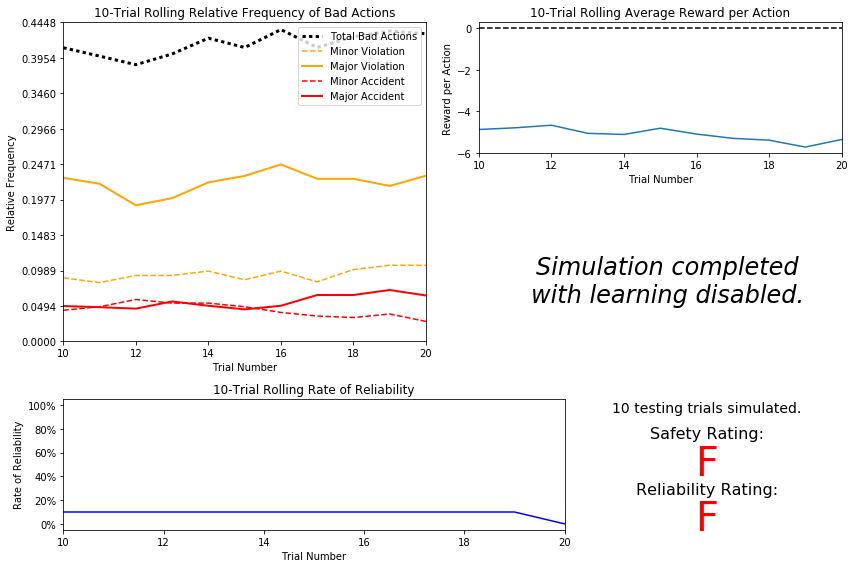

In [4]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### 问题 3
利用上面的从你初始模拟中得到的可视化结果，给出关于驾驶代理程序的分析和若干观察。确保对于可视化结果上的每个面板你至少给出一条观察结果。你可以考虑的一些情况：
- *驾驶代理程序多频繁地做出不良决策？有多少不良决策造成了事故？*
- *假定代理程序是随机驾驶，那么可靠率是否合理？*
- *代理程序对于它的行动会获得什么样的奖励？奖励是否表明了它收到严重的惩罚？*
- *随着试验数增加，结果输出是否有重大变化？*
- *这个智能出租车对于乘客来说，会被人为是安全的且/或可靠的吗？为什么或者为什么不？*

**答案：**

【更改如下】
- total bad actions在37%左右，其中major accident 5% - 8%左右，minor accident 4% 上下；major violation 18%左右，minor violation 9%左右。
- 可靠率在 15%(跑了2次，可靠率40%-20%，和15%左右，都是很低)。作为随机驾驶，没有学习，这个可考虑时合理的。
- 获得的reward per action 平均在 -5上下。表明了它收到的惩罚很严重
- 随着试验数增加，结果输出没有重大变化
- 双F，不安全，不可靠。

------
【第一次提交内容，备份之用。汽车不动是因为跑程序时，没有设置random动作】
车似乎始终静止不动
- 驾驶代理total bad action的频率大约34%～43%。这些不良决策造成的都是小事故，大事故大违章是0。[模拟多次，major Acc./Viol. 都是0]
- 可靠率是0。不可靠。
- Reward都是惩罚负分，-1.25 ～ -0.75之间，惩罚分数不严重。
- 测试了3次，输出结果没有显著的变化。Safty Rating基本都是B，Reliability Rating是F。无major事故。
- 对于乘客，基本安全，因为无重大事故违章，安全级别B；可靠性不及格，是F，10次Trial的可靠性是0%。

---

-----
## 通知驾驶代理程序
创建一个优化Q-Learning的驾驶代理程序的第二步，是定义一系列代理程序会在环境中发生的状态。根据输入、感知数据和驾驶代理程序可用的变量，可以为代理程序定义一系列状态，使它最终可以*学习*在一个状态下它需要执行哪个动作。对于每个状态的`'如果这个处于这个状态就那个行动'`的状况称为**策略**，就是最终驾驶代理程序要学习的。没有定义状态，驾驶代理程序就不会明白哪个动作是最优的——或者甚至不会明白它要关注哪个环境变量和条件！

### 识别状态
查看`'build_state()'`代理程序函数，它显示驾驶代理函数可以从环境中获得下列数据：
- `'waypoint'`，*智能出租车*去向目的地应该行驶的方向，它是*智能出租车*车头方向的相对值。
- `'inputs'`，*智能出租车*的感知器数据。它包括  
  - `'light'`，交通灯颜色。
  - `'left'`，*智能出租车*左侧车辆的目的方向。如果没有车辆，则返回`None`。
  - `'right'`，*智能出租车*右侧车辆的目的方向。如果没有车辆，则返回`None`。
  - `'oncoming'`，*智能出租车*交叉方向车辆的目的方向。如果没有车辆，则返回`None`。
- `'deadline'`，*智能出租车*在时间之内到达目的地还所需的剩余动作数目。

### 问题 4
*代理程序的哪些可用特征与学习**安全性**和**效率**相关性最高？你为什么认为这些特征适合在环境中对**智能出租车**建模？如果你没有选择某些特征，放弃他们的原因是什么？*

**回答：**
- 学习安全性：inputs很重要，light的颜色直接决定车是否应该停止或者前行，left对于车的左转很关键，oncoming十字路的车辆情况对汽车在路口的行为安全很重要。
- 效率方面：waypoint对学习效率有影响
- 【老版更改】right是车的并行的右侧，但是Grid是单排车道，不存在向右并道的可能，所以意义不大。当然，现实世界，我们开车的时候，左右2侧都是需要观察的，甚至后方车辆也要观察，根据四周的车辆状况，作出相应判断。对于这个项目本身，right不需要考虑。
- 【新更改】oncoming是针对交叉方向的，那么，如果路口，汽车想直行，右侧汇入车辆时，是oncoming提示还是right提示？感觉是oncoming提供这个信息。
- 【更改】deadline “智能出租车在时间之内到达目的地还所需的剩余动作数目”；对于学习 安全性 没有positive影响，对于到达效率，有一定的影响。但是，对于本项目，学会安全驾驶优先，所以，deadline暂时不考虑。deadline默认是起始点与终点的5倍，并且随着每一次action，都会少1,是一个metrics。如果把deadline计算入Q-table，会大幅增加状态数量。问题5，选择的状态是96个，如果考虑了deadline，Q-table的状态可能性就会最高达到 96*deadline。例如，如果绿灯，周围无车，智能车正常直接通过路口，如果加入deadline，这一个状态就会被分成不同deadline种状态，计算量会大幅增加。不考虑deadline

### 定义状态空间
当定义一系列代理程序会处于的状态，必需考虑状态空间的*大小*。就是说，如果你期望驾驶代理程序针对每个状态都学习一个**策略**，你会需要对于每一个代理状态都有一个最优的动作。如果所有可能状态的数量非常大，最后会变成这样的状况，驾驶代理程序对于某些状态学不到如何行动，会导致未学习过的决策。例如，考虑用下面的特征定义*智能出租车*的状态的情况：

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.
发生如`(False, True, True, True, False, False, '3AM')`的状态的频次如何？没有近乎无限数量的训练，很怀疑代理程序会学到一个合适的动作！

### 问题 5
*如果用你在**问题4**中选择的特征来定义一个状态，状态空间的大小是多少？假定你了解环境以及它是如何模拟的，你觉得经过合理数量的训练之后，代理驾驶能学到一个较好的策略吗？（遇见绝大部分状态都能作出正确决策。）*
**提示：** 考虑特征*组合*来计算状态的总数！

**回答：**
- waypoint：3个状态：right，left，forward
- inputs：light：红灯，绿灯；left：left，right，forward，none；oncoming：left，right，forward，none。3个属性，2x4x4个状态
- 总数是3x2x4x4 = 96
- 我认为，应该可以学习得到一个较好的策略
- 【之所以之前加入这个，是因为第一次的reviewer提出，deadline的问题，以及组合可能。所以，在之前的提交中，加入了right，给出组合的可能。为了state完整性，right会加入state】如果考虑所有除了deadline以外的状态，及考虑waypoint：3种，所有inputs（light:2种，left：4种，oncoming：4种，right：4种），状态的总数是3x2x4x4x4=384种状态组合。

### 更新驾驶代理程序的状态
要完成你的第二个实现，去到`'build_state()'`代理程序函数。根据你在**问题4**给出的判断，你现在要将`'state'`变量设定为包含所有Q-Learning所需特征的元组。确认你的驾驶代理程序通过运行代理程序文件和模拟会更新它的状态，注意状态是否显示了。如果用了可视化模拟，确认更新的状态和在模拟程序里看到的一致。

**注意：** 观察时记住重置模拟程序的标志到默认设定！

-----
## 实现Q-Learning驾驶代理程序
创建一个优化Q-Learning的驾驶代理程序的第三步，是开始实现Q-Learning自身的功能。Q-Learning的概念相当直接：每个访问的状态，为所有可用的状态-行动配对在Q-table里创建一条记录。然后，当代理程序遇到一个状态并执行了一个动作，基于获得的奖励和设定的相互的更新规则，来更新关联的状态-动作配对的Q-value。当然，Q-Learning还带来其他的收益，如此我们可以让代理程序根据每个可能的状态-动作配对的Q-values，来为每个状态选择*最佳*动作。在这个项目里，你会实现一个*衰减* $\epsilon$ *-贪心* 的Q-learning算法，不含折扣因子。遵从每个代理程序函数的**TODO**下的实现指导。

注意代理程序的属性`self.Q`是一个字典：这就是Q-table的构成。每个状态是`self.Q`字典的键，每个值是另一个字典，包含了*action*和*Q-value*。这里是个样例：

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

此外，注意你要求利用一个*衰减*$\epsilon$*（探索）因子*。因此，随着试验的增加，$\epsilon$会向0减小。这是因为，代理程序会从它的行为中学习，然后根据习得的行为行动。而且当$\epsilon$达到特定阈值后（默认阈值为0.01），代理程序被以它所学到的东西来作检测。作为初始的Q-Learning实现，你将实现一个线性衰减$\epsilon$的函数。

### Q-Learning模拟结果
要从最初的Q-learning程序获得结果，你需要调整下面的标志和设置：
- `'enforce_deadline'` - 将此标志设定为`True`来强制驾驶代理程序捕获它是否在合理时间内到达目的地。
- `'update_delay'` - 将此标志设定为较小数值（比如`0.01`）来减少每次试验中每步之间的时间。
- `'log_metrics'` - 将此标志设定为`True`将模拟结果记录为在`/logs/`目录下的`.csv`文件，Q-table存为`.txt`文件。
- `'n_test'` - 将此标志设定为`'10'`则执行10次测试试验。
- `'learning'` - 将此标志设定为`'True'`来告诉驾驶代理使用你的Q-Learning实现。

此外，使用下面的$\epsilon$衰减函数：

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

如果你在实施时遇到困难，尝试把`'verbose'`标志设为`True`来调试。调试时，在这里设定的标志会返回到它们的默认设定。重要的是你要理解每个标志做什么并且解释它们怎么影响模拟！

当你成功完成初始的Q-Learning模拟程序后，运行下面代码单元格来使结果可视化。注意当相同的模拟运行时，log文件会被覆写，所以要留意载入的log文件！

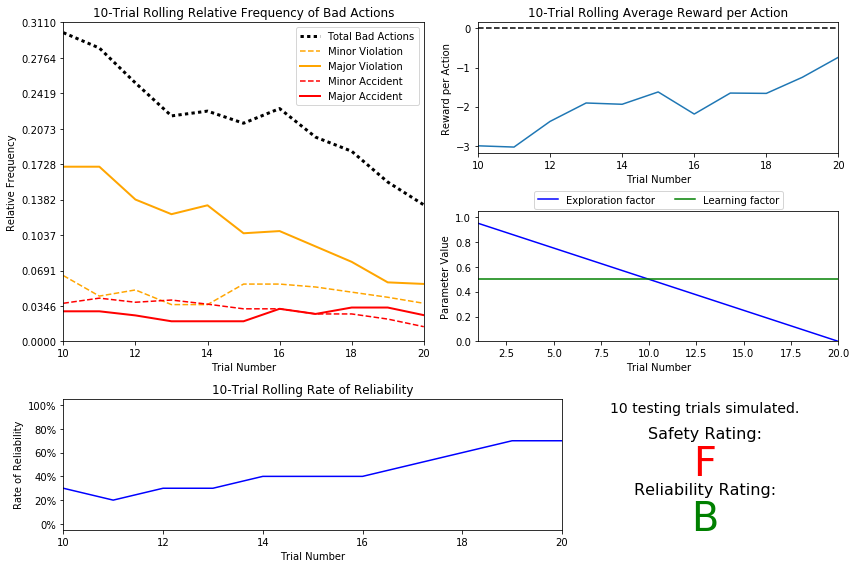

In [3]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### 问题 6
利用上面的从你默认的Q-Learning模拟中得到的可视化结果，像在**问题3**那样，给出关于驾驶代理程序的分析和若干观察。注意模拟程序应该也产生了Q-table存在一个文本文件中，可以帮到你观察代理程序的算法。你可以考虑的一些情况：
- *有没有观察到基本驾驶代理程序和默认的Q-Learning代理程序的相似之处？*
- *在测试之前驾驶代理大约需要做多少训练试验？在给定的$\epsilon$ 容忍度下，这个数字是否合理？*
- *你实现的$\epsilon$（探索因子）衰减函数是否准确地在参数面板中显示？*
- *随着试验数增加，不良动作的数目是否减少?平均奖励是否增加？*
- *与初始的驾驶代理程序相比，安全性和可靠性评分怎样？*

**回答：**
- 之前是B F，现在使用Q-Learning是F B。相似之处就是，分数都不及格。基本的驾驶agent程序，智能车辆没有动作，所以，没有major错误，安全性分数高B，可靠性F。默认的Q-Learning，完善了agent.py后，汽车会运动了，在穿过路口的时候，会有major事故发生，所以，学习不足的情况下，安全性是F，而可靠性分数相对高，B。对于自动驾驶来说，2者的分数都是不足够好的。
- 20次试验。$ \epsilon_{t+1} = \epsilon_{t} - 0.05 $ 是线性的，0.05*20 = 1，在20次试验后，$\epsilon$从1变成0。
- 衰减函数准确的显示了
- 随着试验次数增加，不良动作的数目总体是不断减少，除了major accident和 minor violation并没有随试验次数增加二明显减少（水平震荡）。平均奖励总体是不断增加的，除了中间trial 14-16，震荡。
- 与初始的驾驶程序比，安全性下降（从B变成F），可靠性评分增长（从F变成B）


-----
## 改进Q-Learning驾驶代理程序
创建一个优化Q-Learning的驾驶代理程序的第三步，是执行优化！现在Q-Learning算法已经实现并且驾驶代理程序已经成功学习了，需要调整设定、调节参数让驾驶代理程序学习**安全性**和**效率**。通常这一步需要很多试验和错误，因为某些设定必定会造成更糟糕的学习。要记住的一件事是学习的行为本身和需要的时间：理论上，我们可以允许代理程序用非常非常长的时间来学习；然而，Q-Learning另一个目的是*将没有习得行为的试验试验变为有习得行为的行动*。例如，训练中总让代理程序执行随机动作（如果$\epsilon = 1$并且永不衰减）当然可以使它*学习*，但是不会让它*行动*。当改进你的Q-Learning实现时，要考虑做一个特定的调整的意义，以及它是否逻辑上是否合理。

### 改进Q-Learning的模拟结果
要从最初的Q-learning程序获得结果，你需要调整下面的标志和设置：
- `'enforce_deadline'` - 将此标志设定为`True`来强制驾驶代理程序捕获它是否在合理时间内到达目的地。
- `'update_delay'` - 将此标志设定为较小数值（比如`0.01`）来减少每次试验中每步之间的时间。
- `'log_metrics'` - 将此标志设定为`True`将模拟结果记录为在`/logs/`目录下的`.csv`文件，Q-table存为`.txt`文件。
- `'learning'` - 将此标志设定为`'True'`来告诉驾驶代理使用你的Q-Learning实现。
- `'optimized'` - 将此标志设定为`'True'`来告诉驾驶代理你在执行一个优化版本的Q-Learning实现。

优化Q-Learning代理程序可以调整的额外的标志：
- `'n_test'` - 将此标志设定为某个正数（之前是10）来执行那么多次测试试验。
- `'alpha'` - 将此标志设定为0 - 1之间的实数来调整Q-Learning算法的学习率。
- `'epsilon'` - 将此标志设定为0 - 1之间的实数来调整Q-Learning算法的起始探索因子。
- `'tolerance'` - 将此标志设定为某个较小的大于0的值（默认是0.05）来设定测试的epsilon阈值。

此外，使用一个你选择的$\epsilon$ (探索因子)衰减函数。注意无论你用哪个函数，**一定要以合理的速率衰减**到`'tolerance'`。Q-Learning代理程序到此才可以开始测试。某个衰减函数的例子($t$是试验的数目)：

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$

如果你想的话，你也可以使用$\alpha$ （学习率） 的衰减函数，当然这通常比较少见。如果你这么做了，确保它满足不等式$0 \leq \alpha \leq 1$。
如果你在实施时遇到困难，尝试把`'verbose'`标志设为`True`来调试。调试时，在这里设定的标志会返回到它们的默认设定。重要的是你要理解每个标志做什么并且解释它们怎么影响模拟！

当你成功完成初始的Q-Learning模拟程序后，运行下面代码单元格来使结果可视化，请注意为了达到项目要求你需要在安全性和可靠性上获得至少都为A的评分。注意当相同的模拟运行时，log文件会被覆写，所以要留意载入的log文件！

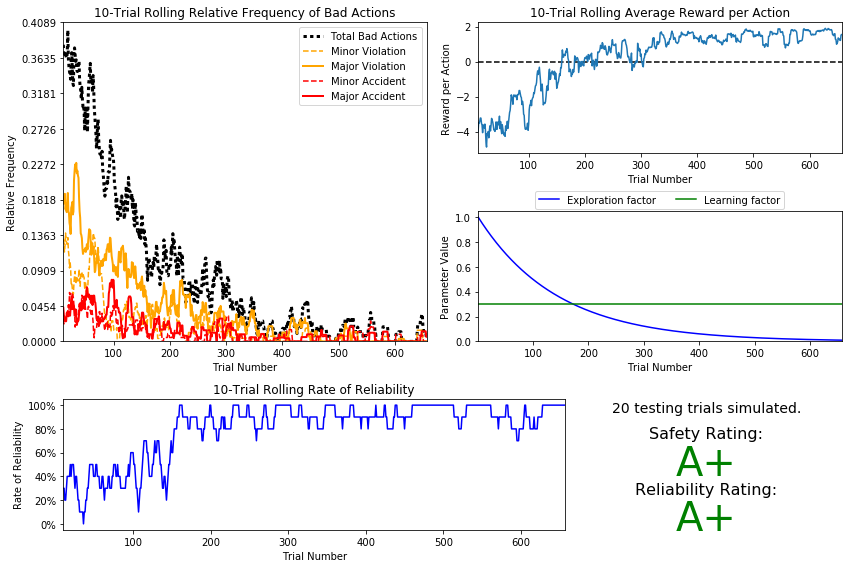

In [12]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### 问题7
利用上面的从你改进的Q-Learning模拟中得到的可视化结果，像在**问题6**那样，给出关于改进的驾驶代理程序的最终分析和观察。你需要回答的问题：
- *使用了什么epsilon（探索因子）的衰减函数？*
- *在测试之前驾驶代理大约需要做多少训练试验？*
- *你用了什么epsilon-tolerance和alpha（学习率）值？为什么？*
- *与之前的默认Q-Learning学习器相比，这个Q-Learning学习器有多少改进？ *
- *你会说Q-Learning学习器的结果表明了你的驾驶代理程序成功地学习了一个合适的策略吗？*
- *你对*智能出租车*的安全性和可靠性评分满意吗？*

**回答：**
- $ \epsilon = a^t $ epsilon = 1, tolerance = 0.01, n_test = 20. 
    - a = 0.9/0.99/0.999 通过增加训练尝试次数，从450次至4500次，成绩从A+／A，达到双A+
    - 学习率alpha在【0，1】，是过去经验的重要性，1表示只使用最近学道的奖励，0表示什么都学不到。如果alpha从0.08降低为0.01，在a=0.9，其他参数不变的情况下，成绩下降，A+／B。所以，学习新的经验，并借鉴过去的经验都很重要，需要找到一个合适的值。
- 与之前的默认Q-Learning比，结果提高了很多，从F／B，达到双A+。双A+的成绩，也表明了驾驶代理成功的学习了一个合适的策略
- 对于A+的安全性和可靠性，满意。

【更改】
- a = 0.9, 45次训练，
    - alpha = 0.3: F／C
    - alpha = 0.5: F／B
    - alpha = 0.6: F／B
- a = 0.99，450次训练
    - alpha = 0.3: A+／A+
    - alpha = 0.5: A+／A+
    - alpha = 0.6: A+／A+
- 选取的state有96个状态，训练450次，就可以达到双A+。只要设置合理的alpha，甚至采用合理的递减alpha函数，会有效的降低达到双A+的训练次数。alpha从0.08变成0.3～0.6，双A+的训练次数从4500降低到了450.同样训练450次，alpha=0.08时，只能达到A+／A。    

【最新更新】
- 将right引入了state，Q-table增加了，trial次数450次不足（安全F）。trial增加到大约600多次，alp=0.5时，A／A+，alp=0.3时，A+／A+

### 定义一个最优策略

有时，对于重要的问题*“我要让我的代理程序学习什么？”*的答案，只是理论性的，无法具体描述。然而这里，你可以具体定义代理程序要学什么，就是美国通行权交通法案。这些法律是已知信息，你可以基于这些法律，为*智能出租车*进一步定义每一个状态所做的最优动作。在那种情况下，我们称这一系列最优状态-动作配对为**最优策略**。因此，不像那些理论性的回答，不仅通过收到的奖励（惩罚），而且纯观察，代理程序是否在“错误”地行动能很清晰地得知。如果代理程序闯了红灯，我们既看见它获得了一个负面奖励，也知道这是一个错误的行为。这可以用来帮你验证驾驶代理程序习得的**策略**是否正确，或只是个**次优策略**。

### 问题 8
给出几个关于最优策略是什么样子的例子（用你已定义的状态）。之后，查看`'sim_improved-learning.txt'`文本文件，看你的改进的Q-Learning算法的结果。_每个从模拟中纪录的状态，对于给定的状态，**策略**（得分最高的动作）是否正确？是否对于有些状态，有策略不同于预期的最优策略？_给出一个状态和记录的状态-动作的奖励，解释为什么正是个正确的策略。

**回答：** state = (waypoint, inputs['light'], inputs['oncoming'], inputs['left'])

- ('forward', 'green', 'right', None) -- forward : 1.82 -- None : -4.49 -- right : 0.82 -- left : -18.79
    - 如果汽车需要前行，绿灯时，汽车应该直行。而上面的这个Q-table，证明了这一点：方向是直行，绿灯时，forward奖励1.82最高分，右转0.82分（分数不高，但交通规则上没有问题）
    
- ('left', 'red', 'right', 'left') -- forward : -4.50 -- None : 1.86 -- right : 0.24 -- left : -17.81
    - 如果汽车需要左转，红灯的时候，汽车需要停留。Q-table中，这种情况，None停留分数最高1.86，最优选择。而闯红灯左转或者直行都是被惩罚；红灯时候，右转在交通规则中也是允许的，但是需要确认交叉路口没有从左往右行驶的汽车（智能车的左侧没有车从左往右行驶），Q-table在这种情况下，对于右转给出了0.24分，是允许右转的，恰好作出的该状态下的所有合法／违法的行为，以及合法行为的最优行为。
    
【更改】 
- 从宏观上，最优的策略是，智能汽车可以在任何状态下，都作出正确的选择，从而能够安全地、迅速地到达目的地。举例来说，汽车在通过一个路口，绿灯状态且周围没有其他车辆，此时，智能汽车可以选择直行，右转，左转。安全性上，这3种选择都是合理的，若目的地在汽车的前方，那么直行就是最佳策略；若目的地在汽车右方，右转就是最佳的策略，其他action虽然是安全性方面是合理的，但是，却不是最佳策略。我们训练的目的就是让汽车学会安全驾驶，另外，最有效率的到达目的地。
- 上面的第一个状态，进一步分析：目的地在汽车的前方forward，所以，绿灯时，虽然汽车可以forward，right，但是，之后forward直行才是最佳策略。右转right，安全性上合理，但是，由于会偏离目的地，只能算是次优策略。


-----
### 选做：未来奖励 - 折扣因子 `'gamma'`
也许你会好奇，作为Q-Learning算法的一部分，之前要求你在实现中**不要**使用折扣引子`'gamma'`。在算法中包含未来奖励能有助于在未来状态回溯到当前状态时的反向正面奖励。本质上，如果给予驾驶代理程序执行若干动作到达不同状态的选择，包含未来奖励会是代理程序偏向可以得到更多奖励的状态。一个例子是驶向目的的驾驶代理程序：所有行动和奖励都相等，那么理论上如果到达目的地会有额外奖励，驶向目的会获得更好的奖励。然而，即使在这个项目里，驾驶代理程序也要在规定的时间里到达目的地，包含未来奖励不会有益于代理程序。实际上，如果代理程序给予多次试验学习，它甚至会给Q-value带来负面影响！

### 可选问题 9
*在项目中有两个特点使得未来奖励在这个Q-Learning算法无效。一个特点是关于*智能出租车*本身，另一个是关于环境。你能指出它们是什么以及为什么未来奖励不会在这个项目中起效？*

**回答：**

> **注意**:当你写完了所有的代码，并且回答了所有的问题。你就可以把你的 iPython Notebook 导出成 HTML 文件。你可以在菜单栏，这样导出**File -> Download as -> HTML (.html)**把这个 HTML 和这个 iPython notebook 一起做为你的作业提交。